In [1]:
import sys
import matplotlib.pyplot as plt
 
# Avoid AttributeError: module 'sqlalchemy' has no attribute 'orm'
import sqlalchemy.orm  # noqa: F401

sys.path.append("..")
from gmo_hft_bot.db.database import SessionLocal
from gmo_hft_bot.db import crud
from backtest.visualize.ohlcv import ohlcv_plot
from backtest.utils.utils import get_ohlcv_df, get_predict_df, match_timestamp_for_ohlcv
from backtest.backtest_trade.richman_backtest import richman_backtest
from backtest.visualize.backtest_visualize import cum_return_plot, position_change_plot, position_change_average_plot


,side,price,size,predict_value,symbol,acutual_timestamp
timestamp,,,,,,
2022-03-15 21:43:05+00:00,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-15 21:43:10+00:00,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-15 21:43:15+00:00,BUY,4575599.0,0.01,1.0,BTC_JPY,2022-03-15 21:43:15+00:00
2022-03-15 21:43:25+00:00,BUY,4573912.0,0.01,1.0,BTC_JPY,2022-03-15 21:43:25+00:00
2022-03-15 21:43:30+00:00,BUY,4573724.0,0.01,1.0,BTC_JPY,2022-03-15 21:43:30+00:00
...,...,...,...,...,...,...
2022-03-15 22:03:00+00:00,BUY,4580732.0,0.01,1.0,BTC_JPY,2022-03-15 22:03:00+00:00
2022-03-15 22:03:05+00:00,BUY,4583129.0,0.01,1.0,BTC_JPY,2022-03-15 22:03:05+00:00
2022-03-15 22:03:10+00:00,BUY,4581707.0,0.01,1.0,BTC_JPY,2022-03-15 22:03:10+00:00


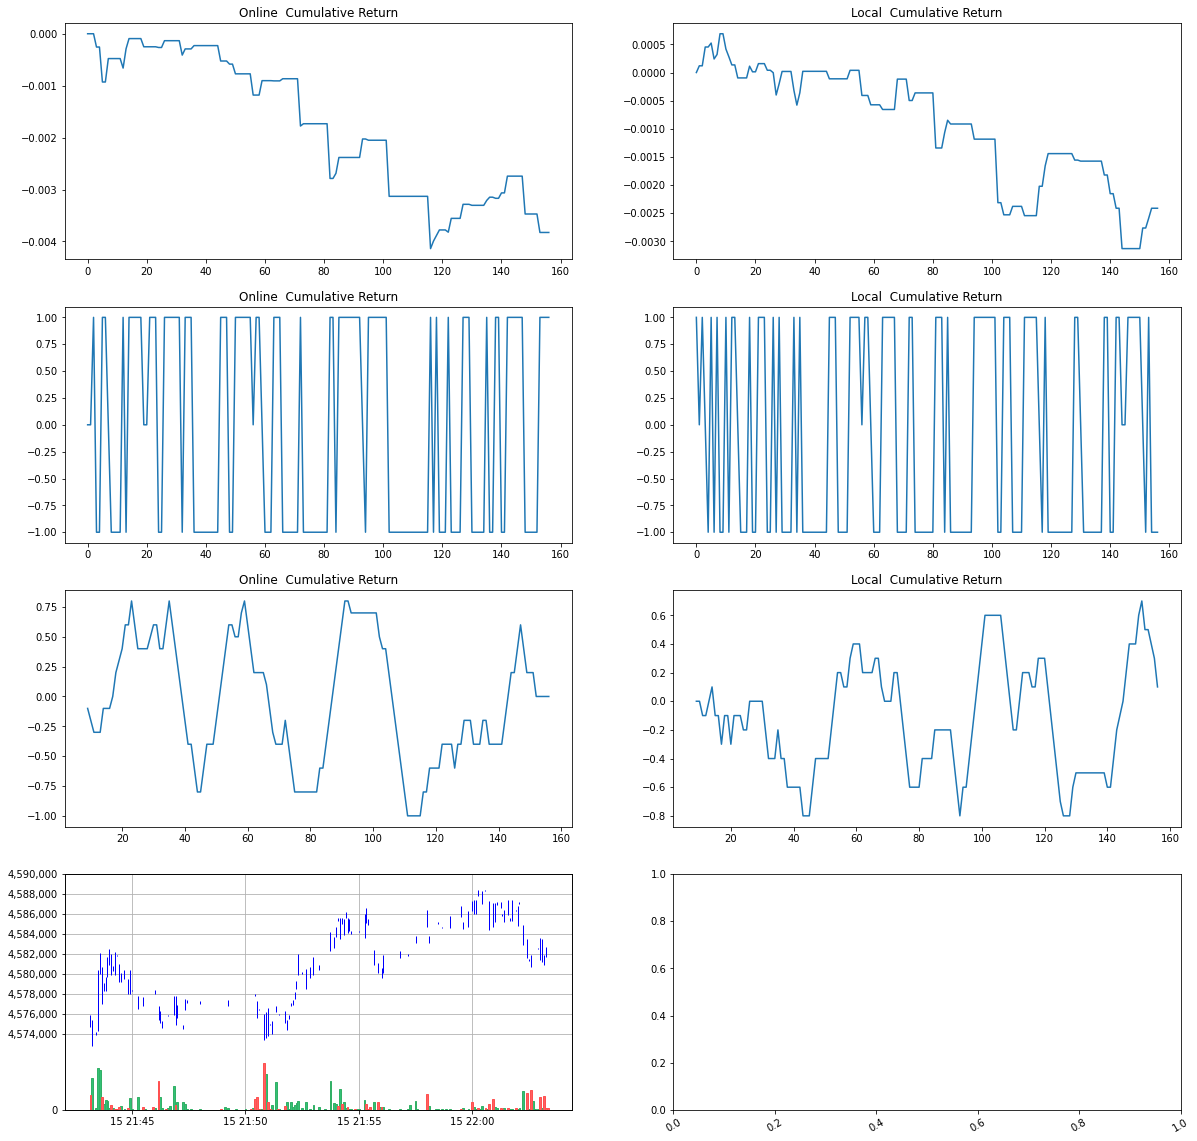

In [2]:
def main():
    symbol = "BTC_JPY"

    with SessionLocal() as db:
        ohlcv_data = crud.get_ohlcv_with_symbol(db=db, symbol=symbol)
        predict_data = crud.get_predict_items(db=db, symbol=symbol)

    # fig, axes = plt.subplots(2, 1, figsize=(16, 8))
    # axes = axes.flatten()

    time_span = 5
    ohlcv_df = get_ohlcv_df(ohlcv_data, time_span=time_span)
    buy_df, sell_df = get_predict_df(predict_data)
    timestamped_buy_df = match_timestamp_for_ohlcv(ohlcv_df, buy_df, time_span)
    timestamped_sell_df = match_timestamp_for_ohlcv(ohlcv_df, sell_df, time_span)
    result_online = richman_backtest(ohlcv_df, buy_df=timestamped_buy_df, sell_df=timestamped_sell_df)

    # local data backtest
    pips = 500
    timestamped_buy_df['price'] = ohlcv_df.loc[:,'close'] - pips
    timestamped_sell_df['price'] = ohlcv_df.loc[:,'close'] + pips
    result_local = richman_backtest(ohlcv_df, buy_df=timestamped_buy_df, sell_df=timestamped_sell_df)

    _, ax = plt.subplots(4, 2, figsize=(20, 20))
    ax = ax.flatten()
    cum_return_plot(ax[0], result_online["cumulative_return"], 'Online')
    cum_return_plot(ax[1], result_local["cumulative_return"], 'Local')
    position_change_plot(ax[2], result_online["position"], 'Online')
    position_change_plot(ax[3], result_local["position"], 'Local')
    position_change_average_plot(ax[4], result_online["position"], 'Online')
    position_change_average_plot(ax[5], result_local["position"], 'Local')
    ohlcv_plot(ax[6], ohlcv_df)
    plt.show()



main()
